In [2]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax_galsim as galsim
import galsim as gs
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import condition , seed , trace
import jax
from functools import partial

/Users/ec270266/anaconda3/envs/shearest/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test galsim HSM

In [3]:
galaxy = gs.Gaussian(flux=1.0, sigma=1.0)
galaxy = galaxy.shear(g1=0.05, g2=-0.05)  # shears the Gaussian by (0.05, 0) using the
                                        # |g| = (a-b)/(a+b) definition
psf = gs.Kolmogorov(flux=1.0, fwhm=0.7)
final = gs.Convolve(galaxy, psf)
final_image = final.drawImage(scale=0.2)
final_epsf_image = psf.drawImage(scale=0.2)
result = gs.hsm.EstimateShear(final_image, final_epsf_image)
print(result)

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=78, ymin=1, ymax=78), moments_status=0, observed_shape=galsim.Shear((0.04389617076922221-0.04389629043791553j)), moments_sigma=5.261084079742432, moments_amp=0.9925428628921509, moments_rho4=2.0109535045851024, moments_n_iter=5, correction_status=0, corrected_e1=0.09910406172275543, corrected_e2=-0.0991005003452301, meas_type='e', corrected_shape_err=0.0, correction_method='REGAUSS', resolution_factor=0.9085153937339783, psf_sigma=1.5978068113327026, psf_shape=galsim.Shear((7.827700927933335e-16-3.267264236939127e-09j)))


# Generate radio data with shear

1.2868265
0.9922888


/Users/ec270266/anaconda3/envs/shearest/lib/python3.13/site-packages/jax/_src/numpy/lax_numpy.py:188: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


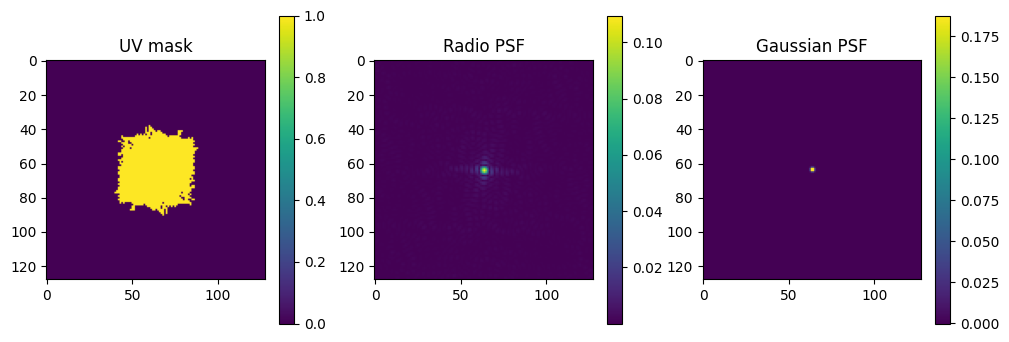

/Users/ec270266/anaconda3/envs/shearest/lib/python3.13/site-packages/jax_galsim/image.py:469: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.zeros(shape=shape, dtype=dtype)
/Users/ec270266/anaconda3/envs/shearest/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [6]:
params_dir = '../../data/trecs_gal_params.npy'

def clip_by_l2_norm(x):
    norm = jnp.linalg.norm(x, axis=0)
    scale = jnp.minimum(1.0, 1. / (norm + 1e-2))  # adding epsilon for numerical stability and enforcing norm < 1.
    return x * scale

x = jnp.array([0.9558077, -0.8615997])
print(jnp.linalg.norm(x))
print(jnp.linalg.norm(clip_by_l2_norm(x)))

def draw_exp_profile(hlr, flux, e1, e2, g1, g2, mask, Npx, pixel_scale):
    gal = galsim.Exponential(half_light_radius=hlr, flux=flux)
    
    # intrinsic ellipticity
    gal = gal.shear(e1=e1, e2=e2)

    # cosmic shear
    gal = gal.shear(g1=g1,g2=g2)

     # Convert to Fourier space
    gal_kimage = gal.drawKImage(nx=Npx, ny=Npx, scale=pixel_scale)
    
    # ADD NOISE

    # Apply the PSF mask in Fourier space
    gal_kobs = gal_kimage.array * mask

    # Convert back to image space
    gal_obs = jnp.fft.ifftshift(jnp.fft.ifft2(gal_kobs))
    
    return jnp.abs(gal_obs)

#@partial(jax.jit, static_argnums=(0,1,2,3,4))
def model_fn(Ngal=10, Npx=128, pixel_scale=0.15, uv_mask=None, sigma_noise=1e-3, obs=None, params_dir=params_dir):

    # define parameters and their prior
    params = np.load(params_dir, allow_pickle=True)[()]
    # pixel_scale = params['pixelscale']
    # Npx = params['Npix']

    u = jnp.ones((Ngal,)) # sampling galaxies all at once

    hlr_fit = params['beta_fit_hlr']
    hlr = numpyro.sample("hlr", dist.Beta(hlr_fit['a'], hlr_fit['b']), sample_shape=(Ngal,)) * hlr_fit['scale'] + hlr_fit['loc']
    # hlr = jnp.abs((numpyro.sample("hlr", dist.Normal(0.*u, 1.*u)) + 4.) * 1.) + 1e-3
    
    flux_fit = params['beta_fit_flux']
    flux = numpyro.sample("flux", dist.Beta(flux_fit['a'], flux_fit['b']), sample_shape=(Ngal,)) * flux_fit['scale'] + flux_fit['loc']
    # flux = jnp.abs((numpyro.sample("flux", dist.Normal(0.*u, 1.*u)) + 10.) * 2.) + 1e-3
    
    # r_ell_fit = params['beta_fit_r_ell']
    # r_ell = numpyro.sample("r_ell", dist.Beta(r_ell_fit['a'], r_ell_fit['b']), sample_shape=(Ngal,)) * r_ell_fit['scale'] + r_ell_fit['loc']
    # angle_ell = numpyro.sample("angle_ell", dist.Uniform(-jnp.pi, jnp.pi), sample_shape=(Ngal,))

    # e1 = r_ell * jnp.cos(angle_ell)
    # e2 = r_ell * jnp.sin(angle_ell)
    e1 = numpyro.sample("e1", dist.Normal(0.*u, 1.*u)) * 0.2
    e2 = numpyro.sample("e2", dist.Normal(0.*u, 1.*u)) * 0.2


    # assuming constant shear across galaxies
    g1 = numpyro.sample("g1", dist.Normal(jnp.zeros((1,)), 1.*jnp.ones((1,)))) * .1
    g2 = numpyro.sample("g2", dist.Normal(jnp.zeros((1,)), 1.*jnp.ones((1,)))) * .1

    # clipping undefined e and g values
    e = jnp.stack([e1, e2], 0)
    e = clip_by_l2_norm(e)

    g = jnp.repeat(jnp.stack([g1, g2], 0), Ngal, -1)
    g = clip_by_l2_norm(g)

    # generate galaxy image
    draw = partial(draw_exp_profile, mask=uv_mask, Npx=Npx, pixel_scale=pixel_scale)
    im_gal = jax.vmap(draw)(hlr=hlr,
                            flux=flux, 
                            e1=e[0], 
                            e2=e[1],
                            g1=g[0], 
                            g2=g[1],)
    
    # add Gaussian noise
    if obs is None:
        return numpyro.sample("obs", dist.Normal(im_gal, sigma_noise))
    else:
        return numpyro.sample("obs", dist.Normal(im_gal, sigma_noise), obs=data)
    

# Dine simulation parameters
Ngal = 100
Npx = 128
pixel_scale = 0.15 # in arcsec/pixel
fov_size = Npx * pixel_scale / 3600 # in degrees
noise = 1e-5
g1_true = -0.05
g2_true = 0.05

# Radio PSF
import argosim
import argosim.antenna_utils
import argosim.imaging_utils
# antenna = argosim.antenna_utils.y_antenna_arr(n_antenna=6, r=1e3)
# antenna = argosim.antenna_utils.random_antenna_arr(n_antenna=80, E_lim=50e3, N_lim=50e3)
# antenna = argosim.antenna_utils.uni_antenna_array(n_antenna_E=10, n_antenna_N=4, E_lim=1e3, N_lim=3e3)
antenna = argosim.antenna_utils.random_antenna_arr(n_antenna=80, E_lim=50e3, N_lim=50e3)
b_enu = argosim.antenna_utils.get_baselines(antenna)
track = argosim.antenna_utils.uv_track_multiband(b_ENU=b_enu, track_time=10, n_times=4, f=1.4e9, df=1e8, n_freqs=4)
mask, _ = argosim.imaging_utils.grid_uv_samples(track, sky_uv_shape=(Npx, Npx), fov_size=(fov_size, fov_size))

# # circular mask
# mask = jnp.ones_like(mask)
# i,j = np.indices(mask.shape)
# r = np.sqrt((i - Npx//2)**2 + (j - Npx//2)**2)
# mask = jnp.where(r < Npx//3, mask, 0.)


plt.subplots(1,3, figsize=(12, 4))
plt.subplot(131)
plt.imshow(np.real(mask))
plt.title('UV mask')
plt.colorbar()
plt.subplot(132)
plt.imshow(np.abs(argosim.imaging_utils.uv2sky(mask)))
plt.title('Radio PSF')
plt.colorbar()
plt.subplot(133)
plt.imshow(galsim.Gaussian(flux=1., sigma=.1).drawImage(nx=Npx, ny=Npx, scale=pixel_scale).array)
plt.title('Gaussian PSF')
plt.colorbar()
plt.show()
# plt.savefig("../outputs/test_radio_psf.pdf")

# Generate observations
key = jax.random.PRNGKey(3)
model = partial(model_fn, Ngal=Ngal, Npx=Npx, pixel_scale=pixel_scale,  uv_mask=mask, sigma_noise=noise)
seeded_model = seed(model, key)

# Conditioning model to generate observation with [g1, g2]
conditionned_model = condition(seeded_model, {"g1":g1_true*jnp.ones((1,))/.1, "g2":g2_true*jnp.ones((1,))/.1})
data = conditionned_model()

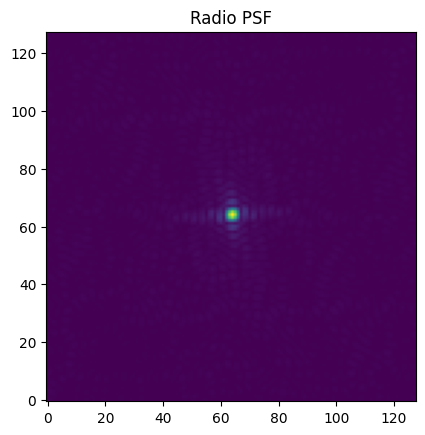

In [7]:
psf = np.abs(argosim.imaging_utils.uv2sky(mask))
pfs_image =  gs.Image(psf, scale=pixel_scale)
pfs_gs = gs.InterpolatedImage(pfs_image)
psf_im = pfs_gs.drawImage(nx=Npx, ny=Npx, scale=pixel_scale)
plt.imshow(psf_im.array, origin='lower')
plt.title('Radio PSF')
plt.show()

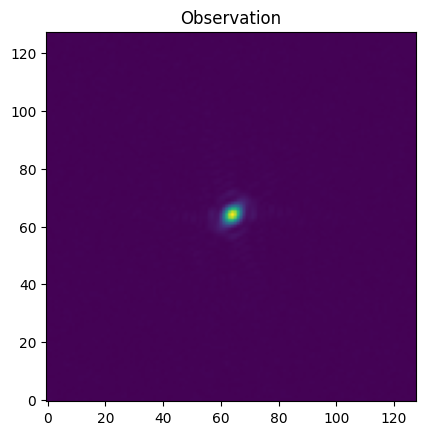

In [13]:
obs = np.array(data[11])
obs_image = gs.Image(obs, scale=pixel_scale)
obs_gs = gs.InterpolatedImage(obs_image)
obs_im = obs_gs.drawImage(nx=Npx, ny=Npx, scale=pixel_scale)
plt.imshow(obs_im.array, origin='lower')
plt.title('Observation')
plt.show()

In [369]:
result = gs.hsm.EstimateShear(obs_im, psf_im, sky_var=noise**2,shear_est='KSB')
print(result)

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=128, ymin=1, ymax=128), moments_status=0, observed_shape=galsim.Shear((-0.05265293718755302+0.12308429585443277j)), moments_sigma=2.1233127117156982, moments_amp=0.08727922290563583, moments_rho4=2.0568215269686725, moments_n_iter=14, correction_status=0, corrected_g1=-0.09239623695611954, corrected_g2=0.29380542039871216, meas_type='g', corrected_shape_err=0.0019330139039084315, correction_method='KSB', resolution_factor=0.44614195823669434, psf_sigma=1.5802041292190552, psf_shape=galsim.Shear((0.010252025030239247+0.03355414792941221j)))


# HSM for the radio data

In [370]:
# shear = result.observed_shape - result.observed_shape
g1 = 0.
g2 = 0.
g1_list = []
g2_list = []
n = 0
err2 = 0.
for obs in np.array(data):
    n += 1
    obs_image = gs.Image(obs, scale=pixel_scale)
    obs_gs = gs.InterpolatedImage(obs_image)
    obs_im = obs_gs.drawImage(nx=Npx, ny=Npx, scale=pixel_scale)
    result = gs.hsm.EstimateShear(obs_im, psf_im, shear_est='REGAUSS')
    # shear += result.observed_shape
    # g1 += result.corrected_g1
    # g2 += result.corrected_g2
    g1 += result.observed_shape.g1
    g2 += result.observed_shape.g2
    g1_list.append(result.observed_shape.g1)
    g2_list.append(result.observed_shape.g2)
    # err2 += result.corrected_shape_err**2

In [371]:
print(np.std(g1_list)/np.sqrt(len(g1_list)), np.std(g2_list)/np.sqrt(len(g2_list)))
print(np.std(g1_list), np.std(g2_list))


0.007656477674254982 0.008083227907305847
0.07656477674254981 0.08083227907305847


In [372]:
err_g1 = 0.
err_g2 = 0.
for g1_, g2_ in zip(g1_list, g2_list):
    err_g1 += (g1/n - g1_)**2
    err_g2 += (g2/n - g2_)**2
err_g1 = np.sqrt(err_g1/n**2)
err_g2 = np.sqrt(err_g2/n**2)
print(err_g1, err_g2)

0.007656477674254981 0.008083227907305845


In [373]:
# print(f"g1: {shear.g1}, g2: {shear.g2}")
print(f"g1: {g1/n}, g2: {g2/n}")
print(f"err: {np.sqrt(err2/n)}")
print(f"err_g1: {err_g1}, err_g2: {err_g2}")

g1: -0.03897210339858006, g2: 0.03885873007991787
err: 0.0
err_g1: 0.007656477674254981, err_g2: 0.008083227907305845


# HMC shear inference

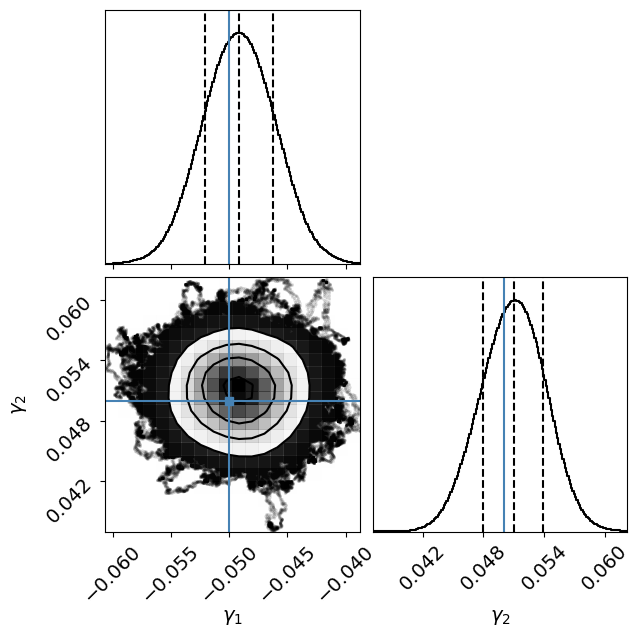

In [374]:
# import samples
samples = np.load('test_radio_samples.npz', allow_pickle=True)
g1_samp = samples["g1"][:,50_000:]
g2_samp = samples["g2"][:,50_000:]
samples_g = np.concatenate([g1_samp, g2_samp], -1).reshape((-1,2)) * 0.1

import corner

two_cols = ["g_1", "g_2"]
two_labels = [r"$\gamma_1$", r"$\gamma_2$"]

fig = plt.figure(figsize=(7, 7))
fig = corner.corner(samples_g,
              truths=([g1_true, g2_true]),
              labels=two_labels,
              fig=fig,
              quantiles=[0.16, 0.5, 0.84],
              smooth=True,
              smooth1d=10.,
              hist_bin_factor=10.,

             )

In [375]:
np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))

array([0.00291869, 0.00293418])

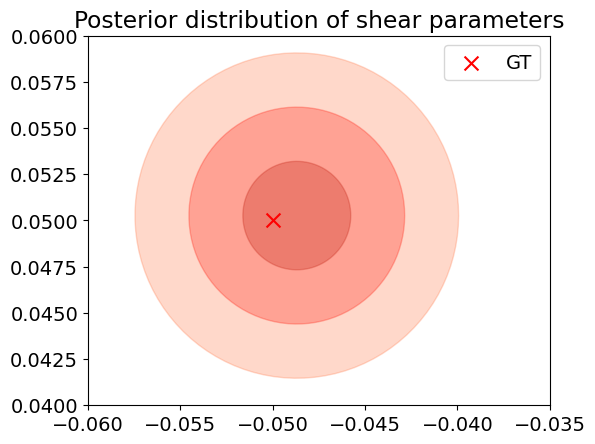

In [376]:
# gaussian fit through the samples
from scipy.stats import multivariate_normal
mean = np.mean(samples_g, axis=0)
cov = np.cov(samples_g, rowvar=False)
# x = np.linspace(-0.06, -0.04, 100)
# y = np.linspace(0.04, 0.06, 100)
# X, Y = np.meshgrid(x, y)
# pos = np.dstack((X, Y))
# rv = multivariate_normal(mean=mean, cov=cov)
# Z = rv.pdf(pos)
theta = np.linspace(0, 2 * np.pi, 100)
x = mean[0] + np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[0] * np.cos(theta)
y = mean[1] + np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[1] * np.sin(theta)
plt.fill(x, y, color='darkred', alpha=0.3)
x2 = mean[0] + 2 * np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[0] * np.cos(theta)
y2 = mean[1] + 2 * np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[1] * np.sin(theta)
plt.fill(x2, y2, color='red', alpha=0.3)
x3 = mean[0] + 3 * np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[0] * np.cos(theta)
y3 = mean[1] + 3 * np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[1] * np.sin(theta)
plt.fill(x3, y3, color='coral', alpha=0.3)

# plt.contourf(X, Y, Z, levels=3, alpha=0.7, cmap='Reds')
plt.scatter(g1_true, g2_true, color='red', marker='x', s=100, label='GT')
plt.legend()
plt.xlim(-0.06, -0.035)
plt.ylim(0.04, 0.06)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Posterior distribution of shear parameters')
# plt.savefig('test_radio_shear_corner.pdf')
plt.show()

# Plot the results

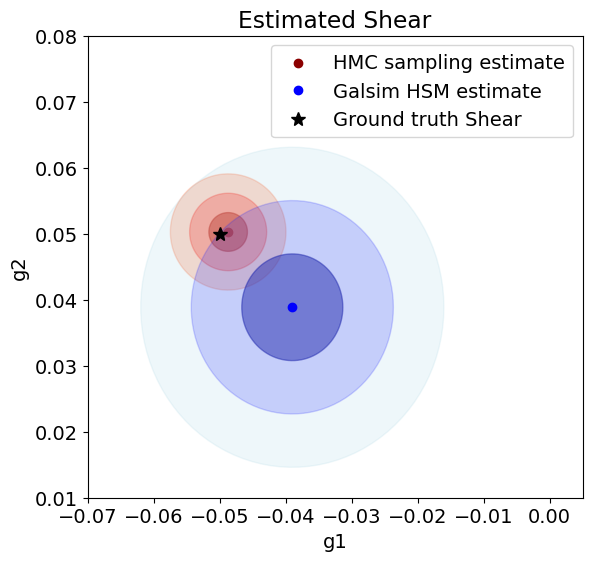

In [377]:
# fontsize
plt.rcParams.update({'font.size': 14})

# Plot estimated shear distribution in 2D (contour)
plt.figure(figsize=(8, 6))
colors = ['white', 'lightcoral', 'red', 'darkred']
# plt.contourf(X, Y, Z, levels=3, alpha=0.9, colors=colors)
plt.scatter(mean[0], mean[1], color='darkred', marker='o', label='HMC sampling estimate')

theta = np.linspace(0, 2 * np.pi, 100)
x = mean[0] + np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[0] * np.cos(theta)
y = mean[1] + np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[1] * np.sin(theta)
plt.fill(x, y, color='darkred', alpha=0.5)
x2 = mean[0] + 2 * np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[0] * np.cos(theta)
y2 = mean[1] + 2 * np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[1] * np.sin(theta)
plt.fill(x2, y2, color='red', alpha=0.3)
x3 = mean[0] + 3 * np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[0] * np.cos(theta)
y3 = mean[1] + 3 * np.sqrt(np.diag(np.cov(samples_g, rowvar=False)))[1] * np.sin(theta)
plt.fill(x3, y3, color='coral', alpha=0.3)



plt.plot(g1/n, g2/n, 'bo', label='Galsim HSM estimate')
plt.plot(g1_true, g2_true, 'k*', markersize=10, label='Ground truth Shear')
# Plot gaussian contourf around the estimated shear
theta = np.linspace(0, 2 * np.pi, 100)
x = g1/n + err_g1 * np.cos(theta)
y = g2/n + err_g2 * np.sin(theta)
plt.fill(x, y, color='darkblue', alpha=0.5)
# plot two and three sigma contours
x2 = g1/n + 2 * err_g1 * np.cos(theta)
y2 = g2/n + 2 * err_g2 * np.sin(theta)
plt.fill(x2, y2, color='blue', alpha=0.2)
x3 = g1/n + 3 * err_g1 * np.cos(theta)
y3 = g2/n + 3 * err_g2 * np.sin(theta)
plt.fill(x3, y3, color='lightblue', alpha=0.2)
plt.xlabel('g1')
plt.ylabel('g2')
plt.title('Estimated Shear')
plt.legend()
# plt.grid()
# plt.axis('equal')
plt.gca().set_aspect('equal')
# plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-0.07, 0.005)
plt.ylim(0.01, 0.08)
plt.show()

